In [98]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [99]:
meme_df = pd.read_csv('data/meme_coins.csv')
stable_df = pd.read_csv('data/stable_coins.csv')

In [100]:
meme_df['Class'] = 0
stable_df['Class'] = 1

In [101]:
df = pd.concat((meme_df, stable_df), axis=0)

In [102]:
df.head(5)

,name,symbol,price,market cap,24h volume,24h,7d,30d,Class
0,Dogecoin,DOGE,$0.1882,$28.60B,$1.81B,6.24%,1.48%,-32.43%,0
1,Shiba Inu,SHIB,$0.000009911,$5.85B,$107.10M,6.19%,-0.50%,-26.02%,0
2,MemeCore,M,$1.90,$3.21B,$10.86M,-1.87%,-15.84%,-25.07%,0
3,Pepe (pepe.vip),PEPE,$0.000006750,$2.80B,$373.36M,6.14%,0.32%,-41.03%,0
4,Pudgy Penguins,PENGU,$0.02146,$1.48B,$170.86M,7.01%,-1.26%,-43.60%,0


In [103]:
df.tail(5)

,name,symbol,price,market cap,24h volume,24h,7d,30d,Class
15,Usual,USD0,$0.9983,$547.24M,$1.02M,-0.00%,-0.01%,0.01%,1
16,USDD,USDD,$0.9998,$498.27M,$1.03M,-0.01%,-0.01%,-0.16%,1
17,Ondo US Dollar Yield Token,USDY,$1.11,$437.70M,$2.34K,0.03%,-0.09%,0.26%,1
18,USDJ,USDJ,$1.21,$331.34M,$3.07M,-0.51%,-1.24%,-8.44%,1
19,EURC,EURC,$1.16,$261.77M,$47.06M,-0.65%,1.47%,-1.28%,1


In [104]:
df.drop(['name'], axis=1, inplace=True)

In [105]:
df.head()

,symbol,price,market cap,24h volume,24h,7d,30d,Class
0,DOGE,$0.1882,$28.60B,$1.81B,6.24%,1.48%,-32.43%,0
1,SHIB,$0.000009911,$5.85B,$107.10M,6.19%,-0.50%,-26.02%,0
2,M,$1.90,$3.21B,$10.86M,-1.87%,-15.84%,-25.07%,0
3,PEPE,$0.000006750,$2.80B,$373.36M,6.14%,0.32%,-41.03%,0
4,PENGU,$0.02146,$1.48B,$170.86M,7.01%,-1.26%,-43.60%,0


In [106]:
def parse_abbreviated_number(value):
    if pd.isna(value):
        return value
    
    value = str(value).strip().replace('$', '').replace(',', '')
    
    multipliers = {
        'K': 10**3, 'M': 10**6, 'B': 10**9, 'T': 10**12
    }
    
    if value[-1].upper() in multipliers:
        number = float(value[:-1])
        multiplier = value[-1].upper()
        return number * multipliers[multiplier]
    else:
        return float(value)

In [107]:
df_pca = df.drop(['symbol'], axis=1)
df_pca = df_pca.drop(['Class'], axis=1)
for col in df_pca.columns:
    if df_pca[col].dtype == 'object':
        df_pca[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\d.-]', '', x))
df_pca['24h'] = df_pca['24h'].map(lambda x: abs(float(x)))
df_pca['7d'] = df_pca['7d'].map(lambda x: abs(float(x)))
df_pca['30d'] = df_pca['30d'].map(lambda x: abs(float(x)))

In [108]:
df_pca.head()

,price,market cap,24h volume,24h,7d,30d
0,0.1882,28.60,1.81,6.24,1.48,32.43
1,0.000009911,5.85,107.10,6.19,0.50,26.02
2,1.90,3.21,10.86,1.87,15.84,25.07
3,0.000006750,2.80,373.36,6.14,0.32,41.03
4,0.02146,1.48,170.86,7.01,1.26,43.60


In [109]:
standard_scaler = StandardScaler()
df_pca = standard_scaler.fit_transform(df_pca)

In [110]:
pca = PCA()
pca_result = pca.fit_transform(df_pca)

In [111]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['symbol'] = df['symbol'].values

In [112]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,symbol
0,0.784509,-0.324619,-0.515292,0.882646,-0.674626,0.153518,DOGE
1,0.487957,-0.734777,-0.759849,0.408401,-0.584519,0.291510,SHIB
2,0.195248,-0.283483,1.733419,0.557927,-0.306452,-1.067854,M
3,0.459417,-1.907106,-1.180917,0.173349,0.645683,0.097818,PEPE
4,0.951551,-1.189871,-0.905555,0.759282,0.020492,0.109773,PENGU


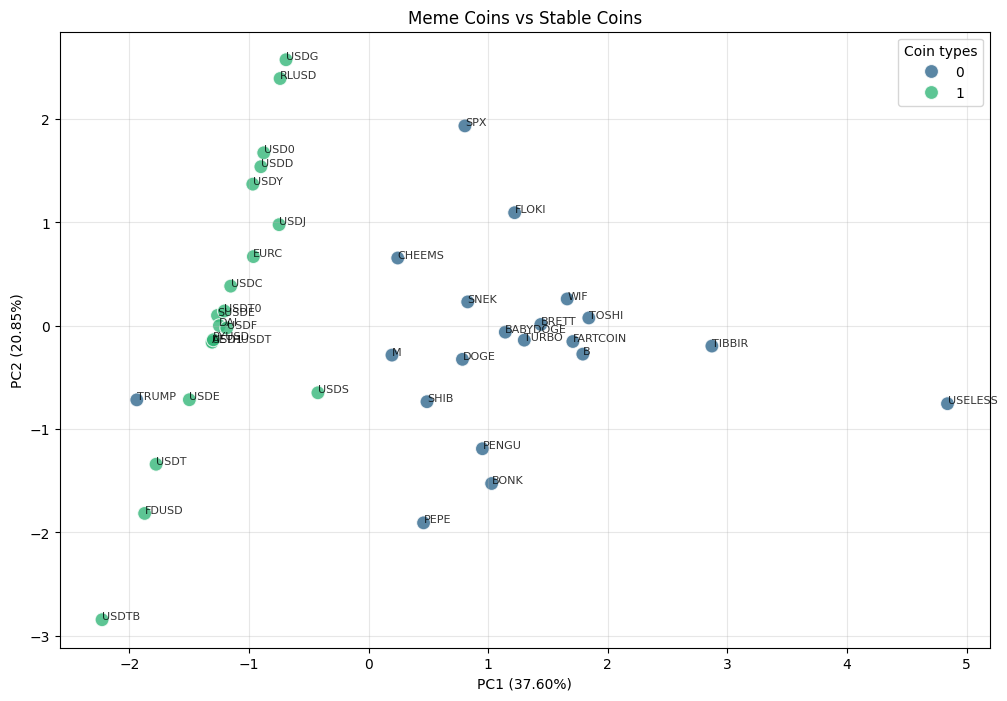

In [113]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [114]:
X = pca_df[['PC1', 'PC2']]
y = df['Class']

In [115]:
knn = KNeighborsClassifier()
knn.fit(X, y)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<Axes: >

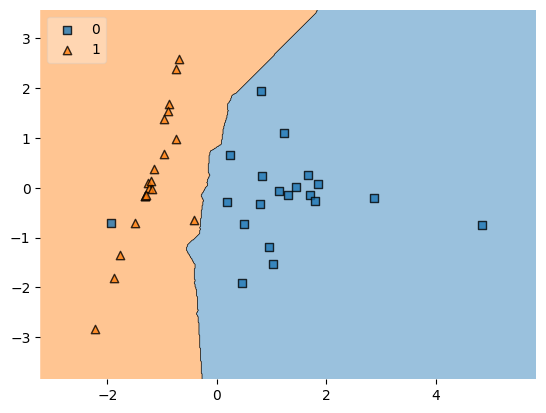

In [116]:
from mlxtend.plotting import plot_decision_regions 
plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=knn, legend=2)  

In [117]:
nearest_centroid = NearestCentroid()
nearest_centroid.fit(X, y)

,metric,'euclidean'
,shrink_threshold,None
,priors,'uniform'


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(


<Axes: >

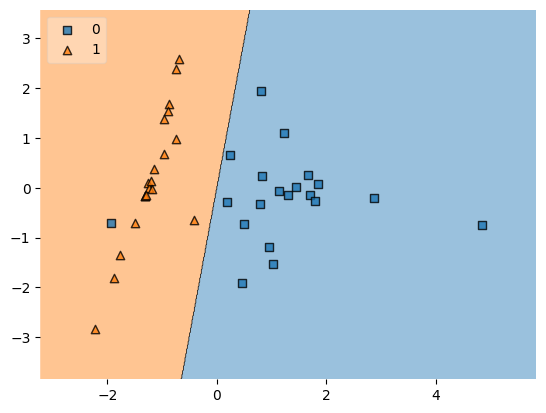

In [118]:
plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=nearest_centroid, legend=2)  

In [119]:
svc_linear = SVC(kernel='linear')
svc_linear.fit(X, y)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


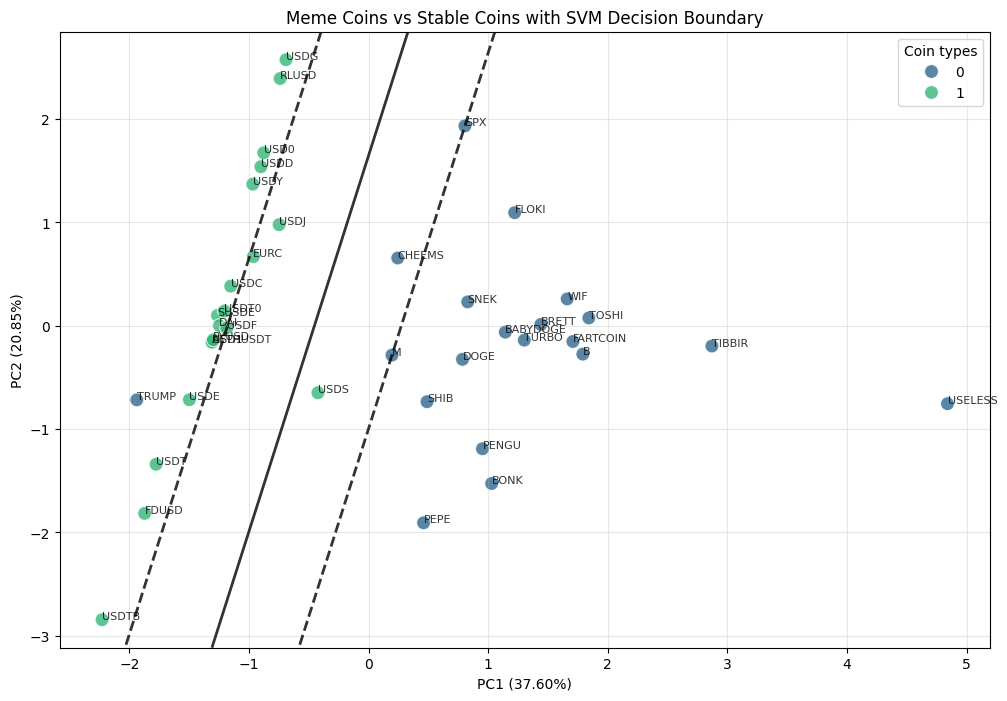

In [120]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_linear.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [121]:
svc_poly = SVC(C=10, kernel='poly')
svc_poly.fit(X, y)

,C,10
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


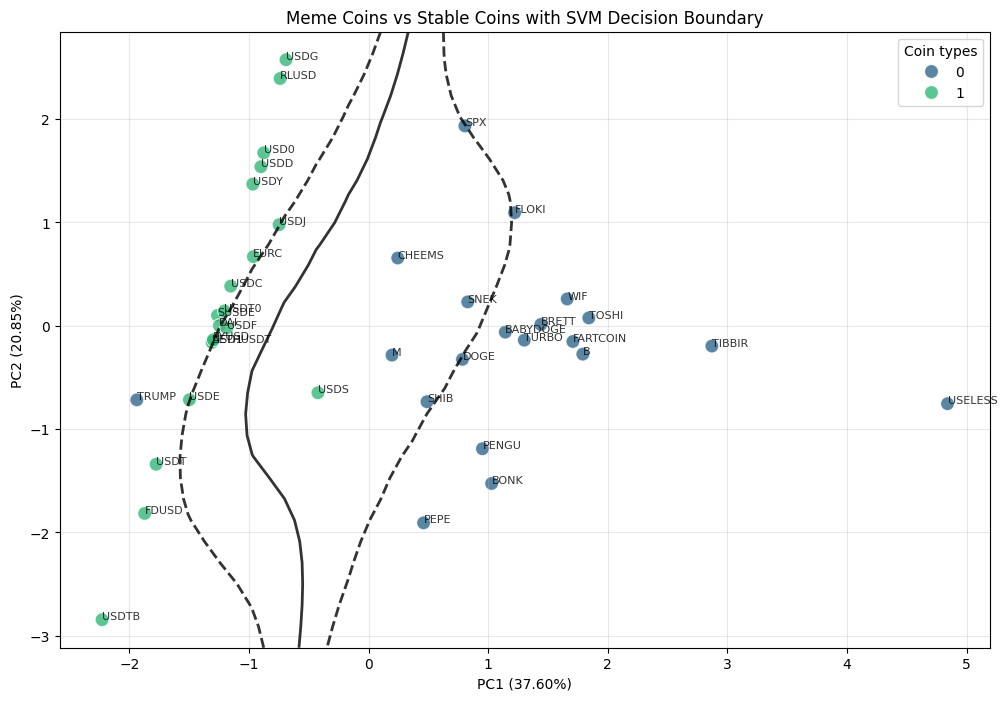

In [122]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_poly.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [123]:
svc_rbf = SVC(C=10, kernel='rbf')
svc_rbf.fit(X, y)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


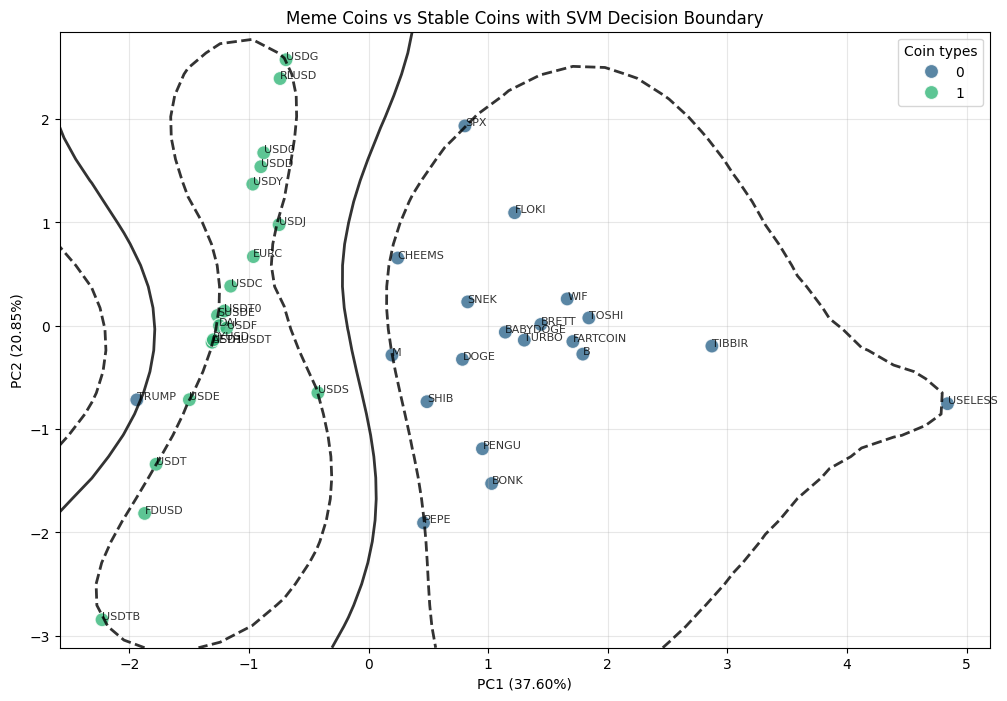

In [124]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_rbf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [125]:
svc_sigmoid = SVC(kernel='sigmoid')
svc_sigmoid.fit(X, y)

,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


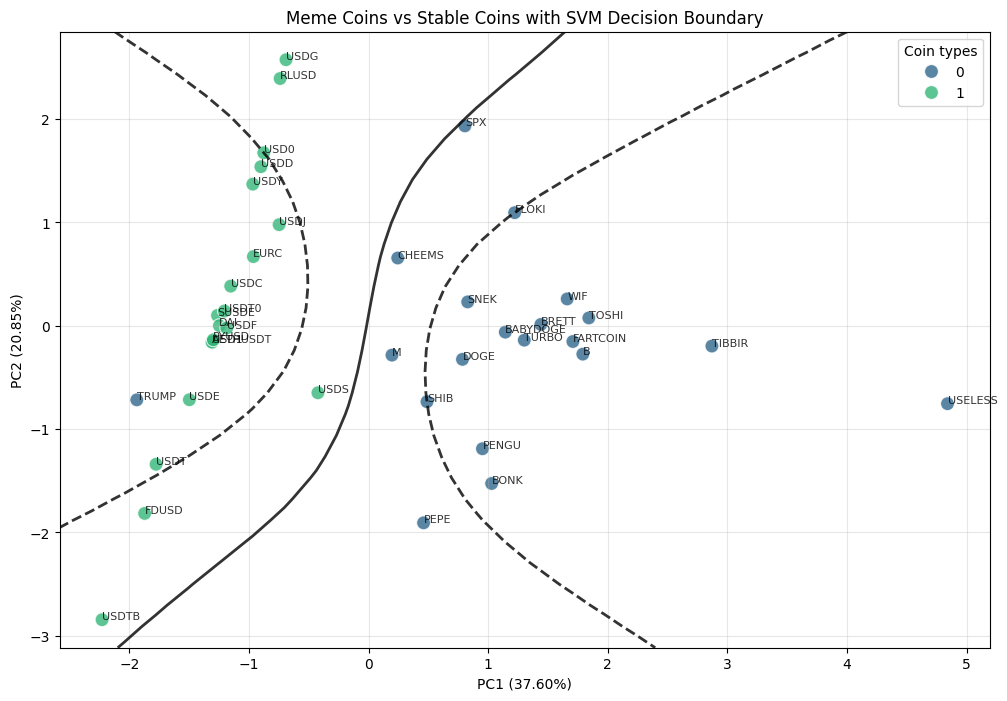

In [126]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_sigmoid.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [127]:
tree = DecisionTreeClassifier()
tree.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


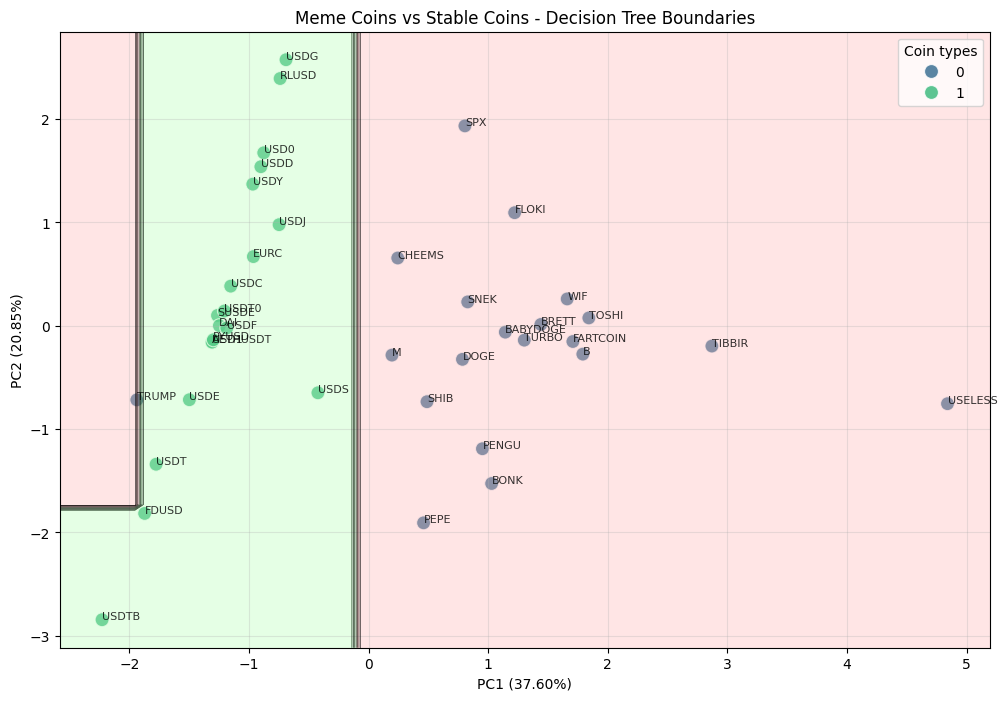

In [128]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = tree.predict(xy)
Z = Z.reshape(XX.shape)

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ['#FF0000', '#00FF00']
plt.contourf(XX, YY, Z, alpha=0.3, cmap=cmap_light)
plt.contour(XX, YY, Z, colors='k', linewidths=0.5, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins - Decision Tree Boundaries')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()